# MECE E4520 Data Science for Mechanical System
## Homework 3: Data Pipeline Design
## Group Member: QI WANG (qw2261), CHAOXUN GU (cg3095)

### 1. Install Packages

In [0]:
!pip install bs4
!pip install scrapy
!pip -qq install datascience # Install datascience package for table
!pip -qq install scikit-learn

import requests
from bs4 import BeautifulSoup
import re # To deal with string
import numpy as np
from datascience import *
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm


### 2. Problem Research
In Homework 3, our group is going to design a data pipeline for a movie website [IMDB](www.imdb.com). We plan to crawl the data from the website for analysis. 

First, we should choose a appropriate web page, [2018 Movies](https://www.imdb.com/search/title?release_date=2018&sort=num_votes,desc&page=1), and do some basic analysis.

In [0]:
# Have a look at the page information

URL = 'https://www.imdb.com/search/title?release_date=2018&sort=num_votes,desc&page=1'

Info = requests.get(URL)

print(Info.text)



<!DOCTYPE html>
<html
    xmlns:og="http://ogp.me/ns#"
    xmlns:fb="http://www.facebook.com/2008/fbml">
    <head>
         
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">

    <meta name="apple-itunes-app" content="app-id=342792525, app-argument=imdb:///?src=mdot">



        <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>

<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
</script>
  <script>(function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);</script>
        <title>IMDb: Released between 2018-01-01 and 2018-12-31
(Sorted by Number of Votes Descending) - IMDb</title>
  <script>(function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);</script>
<script>
    if (typeof uet == 'function') {
      uet("be", "LoadTitle", {wb: 1});
    }
</script>
<script>
 

### From the information above, we can easily find all information of this web page, including information of movies. In order to get the information inside HTML tags, we can use a package bs4 which is based on scrapy.

In [0]:
html_content = BeautifulSoup(Info.text, 'html.parser')

In [0]:
# Because all movies inside a <div> tag named "lister-item mode-advanced", each page we have 50 items

all_movies = html_content.find_all('div', class_ = 'lister-item mode-advanced')
len(all_movies)

50

In [0]:
# Show information of first movie, and we can easily analyze what information we need for analysis

all_movies[0]

<div class="lister-item mode-advanced">
<div class="lister-top-right">
<div class="ribbonize" data-caller="filmosearch" data-tconst="tt4154756"></div>
</div>
<div class="lister-item-image float-left">
<a href="/title/tt4154756/?ref_=adv_li_i"> <img alt="Avengers: Infinity War" class="loadlate" data-tconst="tt4154756" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BMjMxNjY2MDU1OV5BMl5BanBnXkFtZTgwNzY1MTUwNTM@._V1_UX67_CR0,0,67,98_AL_.jpg" src="https://m.media-amazon.com/images/G/01/imdb/images/nopicture/large/film-184890147._CB470041630_.png" width="67"/>
</a> </div>
<div class="lister-item-content">
<h3 class="lister-item-header">
<span class="lister-item-index unbold text-primary">1.</span>
<a href="/title/tt4154756/?ref_=adv_li_tt">Avengers: Infinity War</a>
<span class="lister-item-year text-muted unbold">(2018)</span>
</h3>
<p class="text-muted ">
<span class="certificate">PG-13</span>
<span class="ghost">|</span>
<span class="runtime">149 min</span>
<span class="ghos

In [0]:
# Movie name
first_name = all_movies[0].h3.a.text
print(first_name)

# Movie year 
first_year = all_movies[0].h3.find('span', class_ = 'lister-item-year text-muted unbold').text
print(first_year)

# Movie certificate
first_certificate = all_movies[0].p.find('span', class_ = 'certificate').text
print(first_certificate)

# Movie duration
fist_duration = int(all_movies[0].p.find('span', class_ = 'runtime').text.split(' ')[0])
print(fist_duration)

# Movie genre
first_genre = all_movies[0].p.find('span', class_ = 'genre').text.rstrip().split('\n')[1]
print(first_genre)

# Movie rating
first_rating = float(all_movies[0].strong.text)
print(first_rating)

# Movie metascore
first_metascore = int(all_movies[0].find('span', class_ = 'metascore').text.rstrip())
print(first_metascore)

# Number of votes for this movie
first_votes = int(all_movies[0].find('span', attrs = {'name':'nv'})['data-value'])
print(first_votes)

# Box office of this movie
first_boxoffice = int(re.sub('\D', "", all_movies[0].find('p', class_ = 'sort-num_votes-visible').find('span', attrs = {'name':'nv'}).find_next('span', attrs = {'name':'nv'}).text))
print(first_boxoffice)

Avengers: Infinity War
(2018)
PG-13
149
Action, Adventure, Fantasy
8.5
68
591086
67882


### 3. Data Pipeline Design
The analysis is done and we know how to obtain what we want. Then, we can build a data pipeline to deal with the data.

In [0]:
class MovieData:
  name = np.array([])
  year = np.array([])
  certificate = np.array([])
  duration = np.array([])
  genre = np.array([])
  rating = np.array([])
  metascore = np.array([])
  vote = np.array([])
  boxoffice = np.array([])

In [0]:
def PipeLine(Movies, MovieData):
  
  for each in Movies:
    
    # Skip the cases without metascore, boxoffice and certificate
    condition1 = each.find('span', class_ = 'metascore') is not None
    
    condition2 = True
    try:
      each.find('p', class_ = 'sort-num_votes-visible').find('span', attrs = {'name':'nv'}).find_next('span', attrs = {'name':'nv'}).text
    except AttributeError:
      condition2 = False

    condition3 = True
    try:
      each.p.find('span', class_ = 'certificate').text
    except AttributeError:
      condition3 = False
    
    if condition1 and condition2 and condition3:

      # Movie name
      MovieData.name = np.append(MovieData.name, each.h3.a.text)

      # Movie year
      MovieData.year = np.append(MovieData.year, each.h3.find('span', class_ = 'lister-item-year text-muted unbold').text)

      # Movie certificate
      MovieData.certificate = np.append(MovieData.certificate, each.p.find('span', class_ = 'certificate').text)

      # Movie duration
      MovieData.duration = np.append(MovieData.duration, int(each.p.find('span', class_ = 'runtime').text.split(' ')[0]))

      # Movie genre
      MovieData.genre = np.append(MovieData.genre, each.p.find('span', class_ = 'genre').text.rstrip().split('\n')[1])

      # Movie rating
      MovieData.rating = np.append(MovieData.rating, float(each.strong.text))

      # Movie metascore
      MovieData.metascore = np.append(MovieData.metascore, int(each.find('span', class_ = 'metascore').text.rstrip()))

      # Votes for movie
      MovieData.vote = np.append(MovieData.vote, int(each.find('span', attrs = {'name':'nv'})['data-value']))

      # Boxoffice
      MovieData.boxoffice = np.append(MovieData.boxoffice, int(re.sub('\D', "", each.find('p', class_ = 'sort-num_votes-visible').find('span', attrs = {'name':'nv'}).find_next('span', attrs = {'name':'nv'}).text)))

In [0]:
movieinfo = MovieData()
PipeLine(all_movies, movieinfo)

In [0]:
print('Current data tuples are: ', np.size(movieinfo.name))

Current data tuples are:  47


### 4. More Data Loading

With the data pipeline, we can easily load more data and then do some analysis.

In [0]:
# Load next page

URL = 'https://www.imdb.com/search/title?release_date=2018-01-01,2018-12-31&sort=num_votes,desc&start=51&ref_=adv_nxt'

def LoadNewPage(URL):
  
  Info = requests.get(URL)

  html_content = BeautifulSoup(Info.text, 'html.parser')

  next_page = html_content.find_all('div', class_ = 'lister-item mode-advanced')
  
  return next_page

In [0]:
next_page_movie = LoadNewPage(URL)
PipeLine(next_page_movie, movieinfo)

In [0]:
print('Current data tuples are: ', np.size(movieinfo.name))

Current data tuples are:  83


So, we can keep loading the data.

In [0]:
URL_1 = 'https://www.imdb.com/search/title?release_date=2018-01-01,2018-12-31&sort=num_votes,desc&start='
URL_2 = '&ref_=adv_nxt'

first_value = 101
for i in np.arange(100):
  web_mark = i*50 + first_value
  
  new_page_movie = LoadNewPage(URL_1 + str(web_mark) + URL_2)
  PipeLine(new_page_movie, movieinfo)

In [0]:
print('Current data tuples are: ', np.size(movieinfo.name))

Current data tuples are:  417


### 5. Data Set Presentation
After ingesting the data set, we present what we obtain.

In [0]:
movies = Table().with_columns('Name', movieinfo.name, 'Year', movieinfo.year, 'Certificate', movieinfo.certificate, 'Duration (min)', movieinfo.duration, 'Genre', movieinfo.genre, 'Rating', movieinfo.rating, 'Metascore', movieinfo.metascore, 'Vote', movieinfo.vote, 'Boxoffice (Million $)', movieinfo.boxoffice)

In [0]:
# Store the movie information as a CSV
movies.to_csv('movies.csv')
movies

Name,Year,Certificate,Duration (min),Genre,Rating,Metascore,Vote,Boxoffice (Million $)
Avengers: Infinity War,(2018),PG-13,149,"Action, Adventure, Fantasy",8.5,68,591086,67882
Black Panther,(2018),PG-13,134,"Action, Adventure, Sci-Fi",7.3,88,467637,70006
Deadpool 2,(2018),R,119,"Action, Adventure, Comedy",7.8,66,352578,32459
Ready Player One,(2018),PG-13,140,"Action, Adventure, Sci-Fi",7.5,64,281651,13769
A Quiet Place,(2018),PG-13,90,"Drama, Horror, Mystery",7.6,82,278444,18802
Bohemian Rhapsody,(2018),PG-13,134,"Biography, Drama, Music",8.1,49,272891,21312
Venom,(2018),PG-13,112,"Action, Sci-Fi",6.8,35,238569,21352
Mission: Impossible - Fallout,(2018),PG-13,147,"Action, Adventure, Thriller",7.8,86,216758,22016
Annihilation,(2018),R,115,"Adventure, Drama, Horror",6.9,79,213611,3273
Solo: A Star Wars Story,(2018),PG-13,135,"Action, Adventure, Fantasy",7,62,207070,21377


### 6. Database Schema Design





We will design a non-relational database for the data of IMDB. For example, we can make the name of the movies as the keys and the genres, ratings and some other data as the values. So in this way, the users can easily search the movies by the keys and get some other information of the movies, such as rating and Metascore. On the contrary, if the users only want to search the movies of some specific genres, or just want to know the rating of the movies, they can search by the values and finally they can have the names of movies.

### 7. Data Analysis to Solve Relevant Problems with Data Set

In [0]:
movies = Table().read_table('movies.csv')
size = movies.num_rows
movies

Name,Year,Certificate,Duration (min),Genre,Rating,Metascore,Vote,Boxoffice (Million $)
Avengers: Infinity War,(2018),PG-13,149,"Action, Adventure, Fantasy",8.5,68,591086,67882
Black Panther,(2018),PG-13,134,"Action, Adventure, Sci-Fi",7.3,88,467637,70006
Deadpool 2,(2018),R,119,"Action, Adventure, Comedy",7.8,66,352578,32459
Ready Player One,(2018),PG-13,140,"Action, Adventure, Sci-Fi",7.5,64,281651,13769
A Quiet Place,(2018),PG-13,90,"Drama, Horror, Mystery",7.6,82,278444,18802
Bohemian Rhapsody,(2018),PG-13,134,"Biography, Drama, Music",8.1,49,272891,21312
Venom,(2018),PG-13,112,"Action, Sci-Fi",6.8,35,238569,21352
Mission: Impossible - Fallout,(2018),PG-13,147,"Action, Adventure, Thriller",7.8,86,216758,22016
Annihilation,(2018),R,115,"Adventure, Drama, Horror",6.9,79,213611,3273
Solo: A Star Wars Story,(2018),PG-13,135,"Action, Adventure, Fantasy",7,62,207070,21377


In [0]:
cate = np.array([])

for each in movies.column('Genre'):
  for every in each.split(','):
    cate = np.append(cate, every.lstrip().rstrip())
    
genre = Table().with_column('Genre', cate).group('Genre').relabel('count', 'Number')

print('The genres for movie production in 2018 are')
genre.sort('Number', descending=True).show()


The genres for movie production in 2018 are


Genre,Number
Drama,228
Comedy,111
Action,89
Thriller,76
Crime,67
Adventure,63
Horror,49
Biography,49
Romance,43
Mystery,40


In [0]:
box = np.zeros((1, genre.num_rows))

for i in np.arange(genre.num_rows):
  for j in np.arange(movies.num_rows):
    if genre.column('Genre')[i] in movies.column('Genre')[j]:
      box[0, i] += movies.column('Boxoffice (Million $)')[j]
    
box = box/genre.column('Number')
genre = genre.with_column('Box Office (Million $)', np.round(box[0], 4))

print('The genres for Average Box Office in 2018 are')
genre.sort('Box Office (Million $)',descending=True).show()

The genres for Average Box Office in 2018 are


Genre,Number,Box Office (Million $)
Musical,3,33590.7
Sci-Fi,30,17682
Adventure,63,11920.8
Fantasy,24,11557.2
Music,14,11506.3
Horror,49,10564.2
Animation,18,10442.2
Action,89,9038.78
Family,18,7737.22
Romance,43,7058.23


In [0]:
movie = pd.read_csv('movies.csv')
print('2018 movie information is shown below')
movie.describe()

2018 movie information is shown below


,Duration (min),Rating,Metascore,Vote,Boxoffice (Million $)
count,417.000000,417.000000,417.000000,417.000000,417.000000
mean,105.973621,6.253717,57.062350,27022.563549,6152.141487
std,16.386462,1.014862,17.669398,58992.155820,14123.298188
min,40.000000,3.100000,1.000000,227.000000,0.000000
25%,95.000000,5.600000,45.000000,1485.000000,302.000000
50%,103.000000,6.300000,58.000000,6543.000000,1595.000000
75%,115.000000,7.000000,69.000000,23383.000000,5455.000000
max,188.000000,8.600000,97.000000,591086.000000,181282.000000


In [0]:
#data cleaning
median_office=np.median(movies.column(8))
median_duration=np.median(movies.column(3))
median_rating=np.median(movies.column(5))
median_vote=np.median(movies.column(7))
# We use median of our data to split our data
def isHighbo(boxoffice):
  if boxoffice>median_office:
    return 1
  else:
    return 0
# If the boxoffice of a movie is higher than median of all the boxoffice, then we define that as the high boxoffice, which is 1 in the table.

def isHighdu(duration):
  if duration>median_duration:
    return 1
  else:
    return 0
# If the duration of a movie is higher than median of all the duration, then we define that as the high duration, which is 1 in the table.
  
def isHighra(rating):
  if rating>median_rating:
    return 1
  else:
    return 0
# If the rating of a movie is higher than median of all the rating, then we define that as the high rating, which is 1 in the table.
  
def isHighvote(vote):
  if vote>median_vote:
    return 1
  else:
    return 0
# If the votes of a movie is higher than median of all the votes, then we define that as the high votes, which is 1 in the table.
  
def isAction(genre):
  if 'Action' in genre:
    return 1
  else:
    return 0
# If the genre of a movie contains 'Action', we put 1 in the table.
  
def isAdventure(genre):
  if 'Adventure' in genre:
    return 1
  else:
    return 0
# If the genre of a movie contains 'Adventure', we put 1 in the table.
  
def isRomance(genre):
  if 'Romance' in genre:
    return 1
  else:
    return 0
# If the genre of a movie contains 'Romance', we put 1 in the table.
  
def isComedy(genre):
  if 'Comedy' in genre:
    return 1
  else:
    return 0
# If the genre of a movie contains 'Comedy', we put 1 in the table.

highoffice=movies.apply(isHighbo,'Boxoffice (Million $)')
highduration=movies.apply(isHighdu,'Duration (min)')
highrating=movies.apply(isHighra,'Rating')
highvote=movies.apply(isHighvote,'Vote')
isaction=movies.apply(isAction,'Genre')
isadventure=movies.apply(isAdventure,'Genre')
isromance=movies.apply(isRomance,'Genre')
iscomedy=movies.apply(isComedy,'Genre')
movies=movies.with_columns('isAction',isaction,'isAdventure',isadventure,'isRomance',isromance,'isComedy',iscomedy,'Highoffice',highoffice,'Highduration',highduration,'Highrating',highrating,'Highvote',highvote)
movies

Name,Year,Certificate,Duration (min),Genre,Rating,Metascore,Vote,Boxoffice (Million $),isAction,isAdventure,isRomance,isComedy,Highoffice,Highduration,Highrating,Highvote
Avengers: Infinity War,(2018),PG-13,149,"Action, Adventure, Fantasy",8.5,68,591086,67882,1,1,0,0,1,1,1,1
Black Panther,(2018),PG-13,134,"Action, Adventure, Sci-Fi",7.3,88,467637,70006,1,1,0,0,1,1,1,1
Deadpool 2,(2018),R,119,"Action, Adventure, Comedy",7.8,66,352578,32459,1,1,0,1,1,1,1,1
Ready Player One,(2018),PG-13,140,"Action, Adventure, Sci-Fi",7.5,64,281651,13769,1,1,0,0,1,1,1,1
A Quiet Place,(2018),PG-13,90,"Drama, Horror, Mystery",7.6,82,278444,18802,0,0,0,0,1,0,1,1
Bohemian Rhapsody,(2018),PG-13,134,"Biography, Drama, Music",8.1,49,272891,21312,0,0,0,0,1,1,1,1
Venom,(2018),PG-13,112,"Action, Sci-Fi",6.8,35,238569,21352,1,0,0,0,1,1,1,1
Mission: Impossible - Fallout,(2018),PG-13,147,"Action, Adventure, Thriller",7.8,86,216758,22016,1,1,0,0,1,1,1,1
Annihilation,(2018),R,115,"Adventure, Drama, Horror",6.9,79,213611,3273,0,1,0,0,1,1,1,1
Solo: A Star Wars Story,(2018),PG-13,135,"Action, Adventure, Fantasy",7,62,207070,21377,1,1,0,0,1,1,1,1


[[1.        0.1465776]
 [0.1465776 1.       ]]
The relation between rating and boxoffice:


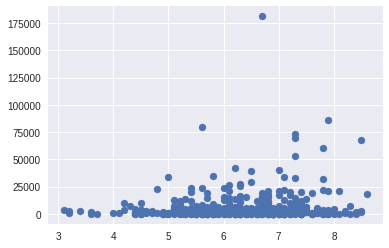

In [0]:
plt.scatter(movies.column(5),movies.column(8))
print(np.corrcoef(movies.column(5),movies.column(8)))
print('The relation between rating and boxoffice:')

[[1.         0.03884368]
 [0.03884368 1.        ]]
The relation between metascore and boxoffice:


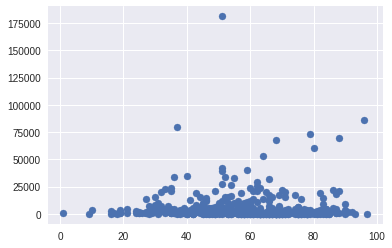

In [0]:
plt.scatter(movies.column(6),movies.column(8))
print(np.corrcoef(movies.column(6),movies.column(8)))
print('The relation between metascore and boxoffice:')

[[1.        0.5404334]
 [0.5404334 1.       ]]
The relation between the number of votes and boxoffice:


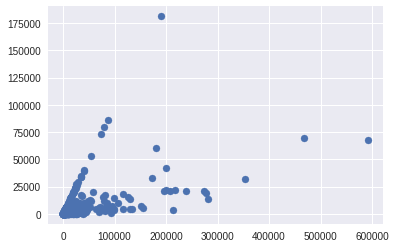

In [0]:
plt.scatter(movies.column(7),movies.column(8))
print(np.corrcoef(movies.column(7),movies.column(8)))
print('The relation between the number of votes and boxoffice:')

Generally we can know from the plot that the correlation coefficients of the rating and boxoffice, metascore and boxoffice are below 0.2, which means there is no such strong relation between them. However, the numbers of votes seem to have positive relation with the boxoffice. I think that is not hard to explain, because the more votes, the more popular is the movie and the audiences are more likely to watch a movie if the movie is popular among people. People perhaps choose to see a movie just because they want to relax themselves or have a topic with their families and friends. So the rating and metascore of a movie might not the most important reason for them to watch a movie.

So now we decide to include more variables into the model to better predict the boxoffice of the movies. In this assignment, we choose to use logistic regression model.

In [0]:

shuffled_movies=movies.sample(with_replacement=False)
training = shuffled_movies.take(np.arange(300)).drop(0,1,2,3,4)
testing = shuffled_movies.take(np.arange(300,size)).drop(0,1,2,3,4)

train_rating=training.column(10)
train_vote=training.column(11)
train_boxoffice=training.column(3)
train_action=training.column(4)
train_adventure=training.column(5)
train_romance=training.column(6)
train_comedy=training.column(7)
train_ho=training.column(8)
train_du=training.column(9)

test_rating=testing.column(10)
test_vote=testing.column(11)
test_boxoffice=testing.column(3)
test_action=testing.column(4)
test_adventure=testing.column(5)
test_romance=testing.column(6)
test_comedy=testing.column(7)
test_ho=testing.column(8)
test_du=testing.column(9)

In [0]:

X_tr=np.stack((train_action,train_adventure,train_romance,train_comedy,train_vote,train_du),axis=1)
X_tt=np.stack((test_action,test_adventure,test_romance,test_comedy,test_vote,test_du),axis=1)
X_tr=sm.add_constant(X_tr)
X_tt=sm.add_constant(X_tt)


model=sm.Logit(train_ho,X_tr).fit()
print(model.summary2())
prediction=(model.predict(X_tt)>0.5)*1
compare=np.equal(prediction,test_ho)
accuracy=np.sum(compare)/np.size(compare)

print("Accuracy of Model = ",accuracy)


Optimization terminated successfully.
         Current function value: 0.586443
         Iterations 6
                        Results: Logit
Model:              Logit            No. Iterations:   6.0000  
Dependent Variable: y                Pseudo R-squared: 0.153   
Date:               2019-02-27 00:05 AIC:              365.8657
No. Observations:   300              BIC:              391.7922
Df Model:           6                Log-Likelihood:   -175.93 
Df Residuals:       293              LL-Null:          -207.78 
Converged:          1.0000           Scale:            1.0000  
-----------------------------------------------------------------
         Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-----------------------------------------------------------------
const   -1.1920     0.2402   -4.9631   0.0000   -1.6628   -0.7213
x1       0.0828     0.3375    0.2454   0.8062   -0.5787    0.7443
x2       1.4104     0.4339    3.2509   0.0012    0.5601    2.2608
x3       0.4050

We put the genres of the movies, numbers of votes and duration as the variables into the model to predict the boxoffice of a movie. As a result, the accuracy of our model is higher than 70% which can effectively predict the boxoffice of the movies.